### Setup and Imports

In [ ]:
!pip install seaborn

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Load and Preprocess Data

In [ ]:
# Load datasets
train = pd.read_csv('/content/Training_Cleaned.csv')
test  = pd.read_csv('/content/Testing_Cleaned.csv')

print("Train shape:", train.shape)
print("Test shape: ", test.shape)

train.head()

Train shape: (263, 133)
Test shape:  (42, 133)


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy


In [ ]:
# Check overlap between training and test sets
common = pd.merge(train, test, how='inner')
print("Overlapping rows:", common.shape[0])


Overlapping rows: 0


### Feature / Target Split

In [ ]:
target = 'prognosis'
X = train.drop(columns=[target])
y = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.transform(y_test)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("Data Ready")


Data Ready


### Baseline Model


Base Model Results:
Accuracy : 0.9762
Precision: 0.9878
Recall   : 0.9878
F1 Score : 0.9837


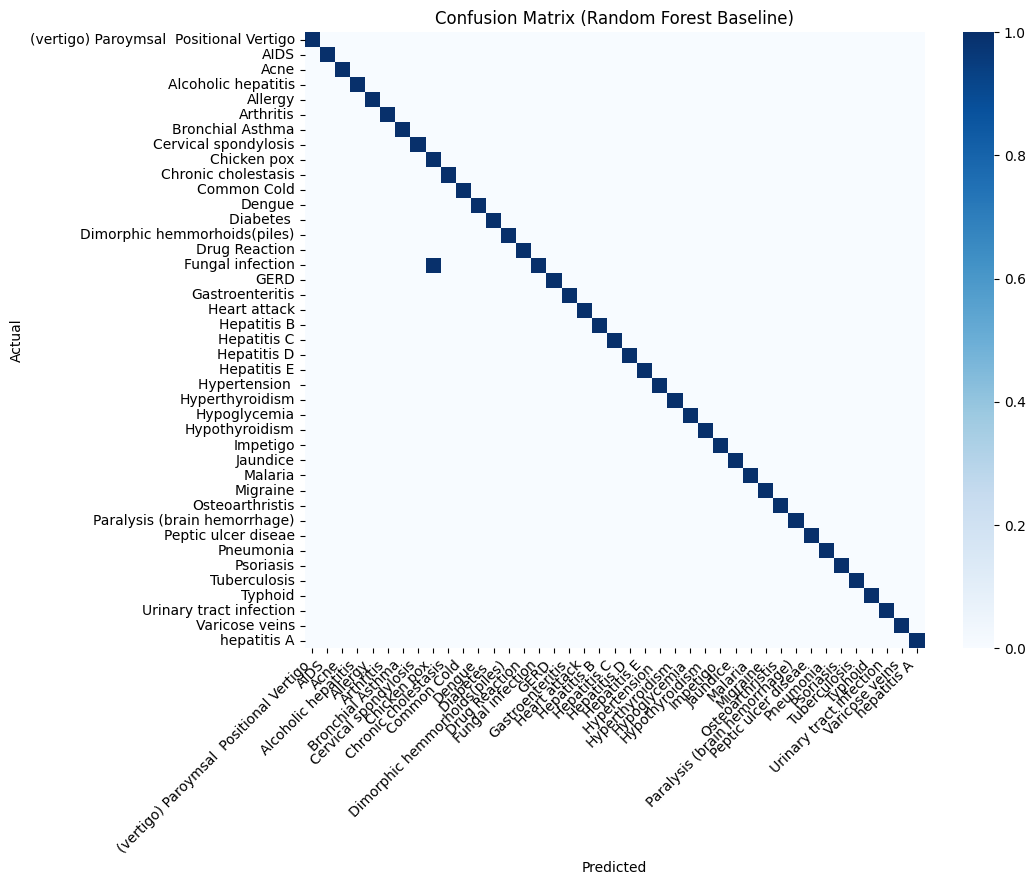

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_scaled, y)
y_pred = rf.predict(X_test_scaled)

# Evaluate baseline model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\nBase Model Results:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest Baseline)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.show()

### Cross Validation

In [ ]:
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')
print("\nCross-validation scores per fold:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Cross-validation scores per fold: [0.98113208 1.         1.         1.         1.        ]
Mean Accuracy: 0.9962264150943396
Standard Deviation: 0.007547169811320752


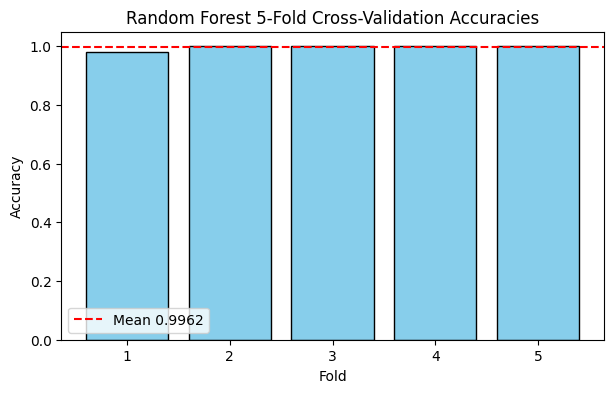

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(range(1, len(cv_scores)+1), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(cv_scores.mean(), color='r', linestyle='--', label=f'Mean {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Random Forest 5-Fold Cross-Validation Accuracies')
plt.legend()
plt.show()

### Hyperparameter Tuning

In [ ]:
print("\nTraining class distribution:")
print(Counter(y))

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Split data for internal validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Internal split -> Train:", X_tr.shape, "Validation:", X_val.shape)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_tr, y_tr)

print("\nBest parameters found:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Best tuned model
best_rf = grid_search.best_estimator_



Training class distribution:
Counter({np.int64(30): 9, np.int64(8): 9, np.int64(11): 9, np.int64(21): 9, np.int64(12): 8, np.int64(28): 8, np.int64(37): 8, np.int64(40): 8, np.int64(19): 8, np.int64(22): 8, np.int64(36): 8, np.int64(10): 8, np.int64(34): 8, np.int64(24): 8, np.int64(25): 8, np.int64(9): 7, np.int64(29): 7, np.int64(3): 7, np.int64(39): 7, np.int64(26): 7, np.int64(16): 6, np.int64(33): 6, np.int64(6): 6, np.int64(20): 6, np.int64(31): 6, np.int64(0): 6, np.int64(35): 6, np.int64(14): 5, np.int64(23): 5, np.int64(7): 5, np.int64(13): 5, np.int64(5): 5, np.int64(27): 5, np.int64(15): 4, np.int64(4): 4, np.int64(1): 4, np.int64(17): 4, np.int64(32): 4, np.int64(18): 4, np.int64(2): 4, np.int64(38): 4})
Internal split -> Train: (210, 132) Validation: (53, 132)
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 1.0

### Test Evaluation

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Tuned Model Performance:
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0


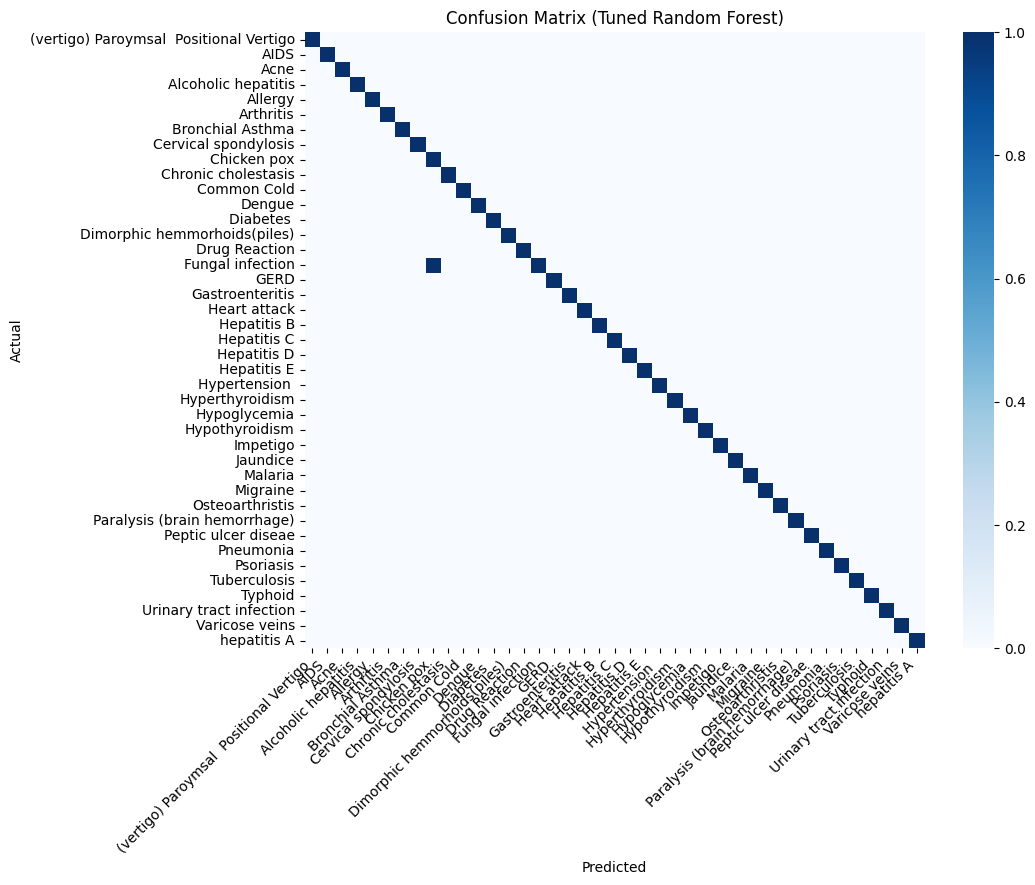

In [ ]:
y_pred_tuned = best_rf.predict(X_test_scaled)

print("\nTuned Model Performance:")
print("Accuracy :", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_tuned, average='weighted'))
print("F1 Score :", f1_score(y_test, y_pred_tuned, average='weighted'))

# Confusion Matrix Visualization
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Tuned Random Forest)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.show()